# Udacity Deep Reinforcement Learning course - Project 3: Collaboration and Competition - Report

In [1]:
from agent import Agent

from unityagents import UnityEnvironment
import numpy as np
import pickle

import torch

## Learning Algorithm

The implemented algorithm was a variation of the Multi-Agent Deep Deterministic Policy Gradients (MADDPG). In this particular case both agents will share all networks Actor and Critic both Local and Target, which is equivalent to having a single agent playing both sides.

The general flow of the algorithm is as follows:

1. Agent selects actions for both players based on the current state for each.
2. The Agent executes the actions. The actor network selects (deterministic) an action and some noise is added for exploration
3. The environment receives both players actions and updates it's state
4. The agent receives the outcome of its action and stores the new experience. This happens for both players.
5. If the appropriate conditions are met the agent learns based on past experiences. The learning process is repeated `learning_passes` times
    a. Sample experiences from the replay buffer
    b. Get next actions based on the target actor network
    c. Get the predicted next-state Q-Values from the target critic network
    d. Compute Q targets for current states
    e. Update local actor and critic networks
    f. Soft-update target networks
6. The loop repeats


The hyper-parameters used are similar to the ones used in the course. With the notable exception of a lower tau.

* buffer_size = 2^22,
* batch_size = 128,
* gamma = 0.99,
* tau = 1e-2,
* lr_actor = 1e-3,
* lr_critic = 1e-3,
* learning_passes = 16,
* starting_noise_factor = 1,
* noise_decay = 0.995,
* update_every = 2^4,
* use_prioritized_replay = False,
* theta = 0.15,
* sigma = 0.2

## Model

The model used for the Actor network is a 3 layer neural network. The first layer is a convolutional layer with one channel in, 32 channels out, a kernel of 8 and a stride of 8. The final two layers are fully connected with 64 and 2(action size) nodes respectivelly. gelu activation functions are used except for the output layer where we use tanh.

The model used for the Critic is a 3 layer fully connected neural network with 128, 128+action_size(2), 64, 1 nodes respectively. We use gelu as the activation function for all layers except the output layer which has no activation function. Note that the first layer uses the state as input and the second concatenates the outputs of the first layer with the embedding of an action.

## Training

In [2]:
with open('scores.pkl', 'rb') as f:
    scores = pickle.load(f)

with open('avg_scores.pkl', 'rb') as f:
    avg_scores = pickle.load(f)

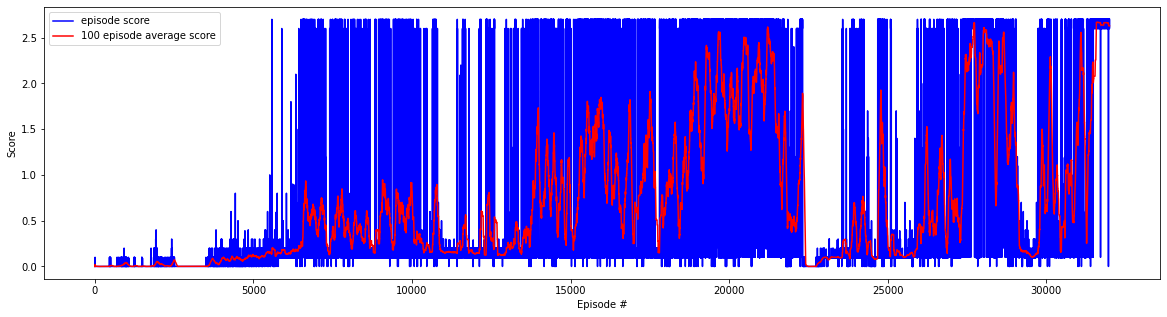

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'b')
plt.plot(np.arange(len(scores)),avg_scores, 'r')
ax.legend(['episode score', '100 episode average score'])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

The environment was solved in 6476 episodes! Average Score: 0.519

The best agent reached an average Score of 2.616 in 21119 episodes (value reached in episode 21219).

## Example run

In [4]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# Value for random seed
seed = 42

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size
# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

In [7]:
agent = Agent(state_size, action_size, seed, model_state_dict_path=".")

Loading actor from: ./checkpoint_actor.pth
Loading critic from: ./checkpoint_critic.pth


In [8]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = [agent.act(state.reshape([1,state.shape[0]])) for state in states]              # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.4000000059604645
Score (max over agents) from episode 2: 0.4000000059604645
Score (max over agents) from episode 3: 0.19000000320374966
Score (max over agents) from episode 4: 0.7000000104308128
Score (max over agents) from episode 5: 0.10000000149011612


In [9]:
env.close()

## Future steps

* Explore using two agents (instead of the single one used)
* Further hyper-parameter optimization
* Finish implementing priority experience replay